In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from time_series_service import series_to_supervised

In [2]:
# Read and prepare data to LSTM time series model

df = pd.read_csv('generated/btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df.sort_values('DateTime')

df.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
9,2020-07-01,0.0,0.741,0.259,0.8126,9229.9
360,2020-07-02,0.0,0.000,0.000,0.0000,9085.1
359,2020-07-03,0.0,0.000,0.000,0.0000,9067.1
358,2020-07-04,0.0,0.000,0.000,0.0000,9134.4
357,2020-07-05,0.0,0.000,0.000,0.0000,9081.0


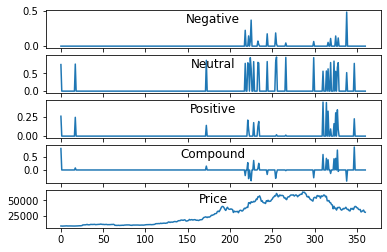

In [3]:
# Plot the time series of all features

values = df.values
groups = [1,2,3,4,5]
i = 1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='center')
	i += 1
plt.show()

In [4]:
# Set the index to DateTime column and move Price column to first place

df.set_index('DateTime',inplace=True)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [5]:
# Reframe the data so we can apply supervised learning techniques in a time series

n_days = 1
n_features = 5
n_obs = n_days * n_features

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

reframed = series_to_supervised(scaled, n_days, 1)

reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.002989,0.0,0.77918,0.583333,0.956370,0.000330
2,0.000330,0.0,0.00000,0.000000,0.326643,0.000000
3,0.000000,0.0,0.00000,0.000000,0.326643,0.001235
4,0.001235,0.0,0.00000,0.000000,0.326643,0.000255
5,0.000255,0.0,0.00000,0.000000,0.326643,0.004991


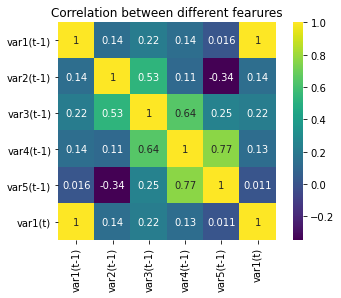

In [6]:
# Plot correlation matrix

correlation = reframed.corr()
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between different fearures')
plt.show();

In [7]:
# Split train and test data

non_zero_condition = reframed['var5(t-1)'].round(4) != 0.3266

zeros_df = reframed[~non_zero_condition].sort_values('var1(t)')
non_zeros_df = reframed[non_zero_condition].sort_values('var1(t)')

zeros_train_size = 0.7
non_zeros_train_size = 0.75

zeros_n_train_days = int(len(zeros_df)*zeros_train_size)
zeros_n_test_days =len(zeros_df) - zeros_n_train_days
non_zeros_n_train_days = int(len(non_zeros_df)*non_zeros_train_size)
non_zeros_n_test_days = len(non_zeros_df) - non_zeros_n_train_days

non_zero_test_step = int(len(non_zeros_df)/non_zeros_n_test_days)
zero_test_step = int(len(zeros_df)/zeros_n_test_days)

non_zero_test = non_zeros_df[::non_zero_test_step]
non_zero_train = pd.merge(non_zeros_df,non_zero_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

zero_test = zeros_df[::zero_test_step]
zero_train = pd.merge(zeros_df,zero_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

train = shuffle(pd.concat((non_zero_train, zero_train))).values
test = shuffle(pd.concat((non_zero_test, zero_test))).values

train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

Epoch 1/20
60/60 - 2s - loss: 0.0325 - val_loss: 0.0223
Epoch 2/20
60/60 - 0s - loss: 0.0171 - val_loss: 0.0141
Epoch 3/20
60/60 - 0s - loss: 0.0133 - val_loss: 0.0123
Epoch 4/20
60/60 - 0s - loss: 0.0118 - val_loss: 0.0112
Epoch 5/20
60/60 - 0s - loss: 0.0111 - val_loss: 0.0102
Epoch 6/20
60/60 - 0s - loss: 0.0106 - val_loss: 0.0097
Epoch 7/20
60/60 - 0s - loss: 0.0103 - val_loss: 0.0093
Epoch 8/20
60/60 - 0s - loss: 0.0097 - val_loss: 0.0090
Epoch 9/20
60/60 - 0s - loss: 0.0095 - val_loss: 0.0087
Epoch 10/20
60/60 - 0s - loss: 0.0091 - val_loss: 0.0084
Epoch 11/20
60/60 - 0s - loss: 0.0089 - val_loss: 0.0081
Epoch 12/20
60/60 - 0s - loss: 0.0086 - val_loss: 0.0079
Epoch 13/20
60/60 - 0s - loss: 0.0083 - val_loss: 0.0076
Epoch 14/20
60/60 - 0s - loss: 0.0079 - val_loss: 0.0076
Epoch 15/20
60/60 - 0s - loss: 0.0077 - val_loss: 0.0070
Epoch 16/20
60/60 - 0s - loss: 0.0073 - val_loss: 0.0068
Epoch 17/20
60/60 - 0s - loss: 0.0069 - val_loss: 0.0066
Epoch 18/20
60/60 - 0s - loss: 0.0068 - 

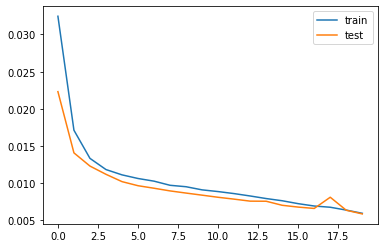

In [8]:
# Create the LSTM model, train it and plot the value loss

model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

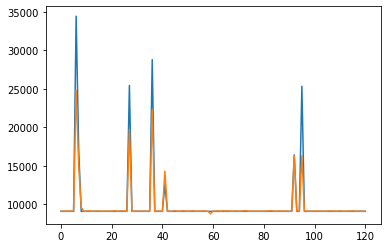

In [9]:
# Make predictions and plot

predictions = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days * n_features))

inv_predictions = np.concatenate((predictions, test_X[:, -4:]), axis=1)
inv_predictions = scaler.inverse_transform(inv_predictions)
inv_predictions = inv_predictions[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.plot(inv_y)
plt.plot(inv_predictions)
plt.show()

In [10]:
# Print the results

mse = mean_squared_error(inv_y, inv_predictions)
r2 = r2_score(inv_y, inv_predictions)
rmse = np.sqrt(mse)

print("Coefficient of Determination  (R2):", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Square Error: %.3f" % rmse)

Coefficient of Determination  (R2): 0.8411958052460734
Mean Squared Error (MSE): 2120808.89672612
Root Mean Square Error: 1456.300


In [11]:
# Save the predictions data to csv file

df_sol = pd.DataFrame({'forecast':inv_predictions,'actual':inv_y})
df_sol.to_csv('generated/predictions_lstm.csv')